In [3]:
# Import and Load Config

import sys
sys.path.append(".")

import torch 

from omegaconf import OmegaConf

from dmm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    # model.cpu()
    model.eval()
    return model

# Download the ckpt file at: https://alteredstatemachine-my.sharepoint.com/:u:/g/personal/michael_hu_alteredstatemachine_xyz/Ed2DNniBrs9JnEhS-p9PvqUB3_nPO0ewXJq3exPzOMKZlw?e=fVwnQ8

def get_model():
    config = OmegaConf.load("/home/hu/audio-diffusion/configs/cond_1.5.yaml")  
    model = load_model_from_config(config, "/home/hu/audio-diffusion/logs/2022-12-22T05-17-20_cond_1.5/checkpoints/last.ckpt")
    return model

In [4]:
# Load Model and Sampler

from dmm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model) # TODO: Modify this for the uncond model

Loading model from /home/hu/audio-diffusion/logs/2022-12-22T05-17-20_cond_1.5/checkpoints/last.ckpt


/home/hu/miniconda3/envs/th/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.encoder.layers.13.mlp.fc1.bias', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.enco

Restored from v1-5-pruned.ckpt with 0 missing and 688 unexpected keys
Unexpected Keys: ['model_ema.decay', 'model_ema.num_updates', 'model_ema.diffusion_modeltime_embed0weight', 'model_ema.diffusion_modeltime_embed0bias', 'model_ema.diffusion_modeltime_embed2weight', 'model_ema.diffusion_modeltime_embed2bias', 'model_ema.diffusion_modelinput_blocks00weight', 'model_ema.diffusion_modelinput_blocks00bias', 'model_ema.diffusion_modelinput_blocks10in_layers0weight', 'model_ema.diffusion_modelinput_blocks10in_layers0bias', 'model_ema.diffusion_modelinput_blocks10in_layers2weight', 'model_ema.diffusion_modelinput_blocks10in_layers2bias', 'model_ema.diffusion_modelinput_blocks10emb_layers1weight', 'model_ema.diffusion_modelinput_blocks10emb_layers1bias', 'model_ema.diffusion_modelinput_blocks10out_layers0weight', 'model_ema.diffusion_modelinput_blocks10out_layers0bias', 'model_ema.diffusion_modelinput_blocks10out_layers3weight', 'model_ema.diffusion_modelinput_blocks10out_layers3bias', 'model

A classical sampling methods:

In [ ]:
# Local RTX3070 Need around 3 mins to generate 1 sample

a = model.sample(batch_size=1)

In [ ]:
# Plot the sample

images = (a / 2 + 0.5).clamp(0, 1)
images = (images.cpu().permute(0,2,3,1).numpy() * 255).round().astype("uint8")
images = list(
    map(lambda _: Image.fromarray(_[:, :, 0]), images)
    if images.shape[3] == 1
    else map(lambda _: Image.fromarray(_, mode="RGB").convert("L"), images)
)
display(images[0])

In [2]:
# Image to Audio Function
import librosa
from librosa.beat import beat_track
from IPython.display import Audio
import numpy as np

from PIL import Image 

def image_to_audio(image: Image.Image) -> np.ndarray:
    """Converts spectrogram to audio.

    Args:
        image (np.ndarray): x_res x y_res grayscale image

    Returns:
        audio (np.ndarray): raw audio
    """
    bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
    log_S = bytedata.astype("float") * 80 / 255 - 80 # top_db: 80
    S = librosa.db_to_power(log_S)
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=22050, n_fft=2048, hop_length=512, n_iter=32
    )
    return audio


def loop_it(audio: np.ndarray,
            sample_rate: int = 22050,
            loops: int = 10) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

In [ ]:
# Display the audio
audio = image_to_audio(images[0])

audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))

A fast sampling methods:

rendering 1 examples in 100 steps
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


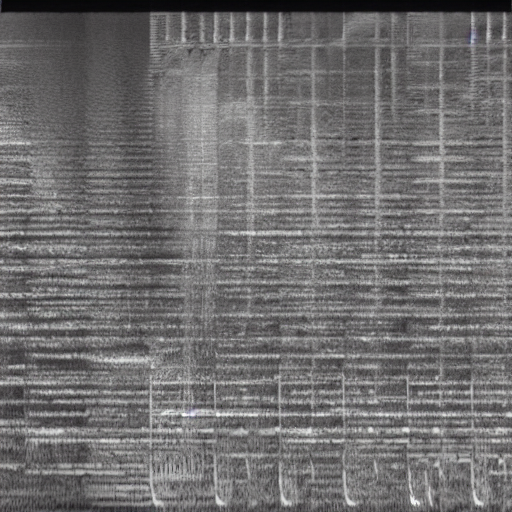

In [81]:
# Faster but noisy
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 100
ddim_eta = 0.0


prompts = ["The genre is ambient. piano and violin."]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=2.5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [82]:
from dmm.util import wav_bytes_from_spectrogram_image

wav = wav_bytes_from_spectrogram_image(Image.fromarray(grid.astype(np.uint8)))

In [83]:
from IPython.display import Audio
display(Audio(wav[0], rate=44100))


In [88]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 100
ddim_eta = 0.0


prompts = ["ambient. piano and violin."]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=1.5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
from dmm.util import wav_bytes_from_spectrogram_image

wav = wav_bytes_from_spectrogram_image(Image.fromarray(grid.astype(np.uint8)))
from IPython.display import Audio
display(Audio(wav[0], rate=44100))

rendering 1 examples in 100 steps
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


In [87]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 100
ddim_eta = 0.0


prompts = ["ambient. piano and violin."]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=3.5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
from dmm.util import wav_bytes_from_spectrogram_image

wav = wav_bytes_from_spectrogram_image(Image.fromarray(grid.astype(np.uint8)))
from IPython.display import Audio
display(Audio(wav[0], rate=44100))

rendering 1 examples in 100 steps
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


In [89]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 100
ddim_eta = 0.0


prompts = ["ambient. piano and violin."]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=5., # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
from dmm.util import wav_bytes_from_spectrogram_image

wav = wav_bytes_from_spectrogram_image(Image.fromarray(grid.astype(np.uint8)))
from IPython.display import Audio
display(Audio(wav[0], rate=44100))

rendering 1 examples in 100 steps
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


In [92]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 100
ddim_eta = 0.0


prompts = ["dance. drumb and violin."]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=5., # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
from dmm.util import wav_bytes_from_spectrogram_image

wav = wav_bytes_from_spectrogram_image(Image.fromarray(grid.astype(np.uint8)))
from IPython.display import Audio
display(Audio(wav[0], rate=44100))

rendering 1 examples in 100 steps
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]
